<a href="https://colab.research.google.com/github/EvgSkv/virtual_people_examples/blob/evgenys%2Fdev/notebooks/Consistent_Hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consistent Hashing in Reach Modeling

[@evgskv](https://github.com/EvgSkv/)

Google LLC

May 2021


Random choices inside of reach model should be done based on the hash of the user identifier in such a way that small changes of probability distribution should cause a small number of cookies to change the virtual person ID and labels. This is required, so that the model can report on intervals that span across model release with best possible quality.

This type of random choice is called _consistent hashing_ and there exists [plenty of literature](https://scholar.google.com/scholar?q=consistent+hashing) on the subject.

Here we describe a simple method of making this choice that is linear in the number of options and can accomodate arbitrary desired probability distribution over the options.

**Problem:** Given a set of choices $\{c_0, c_1, \dots, c_{n-1}\}$, a probability distribution $p: c_i \mapsto [0, 1]$, build a hash function $h_p$ with the properties:

1) Distribution $p$ is followed, i.e. for a random object $x$  we have $P(h_p(x) = c_i) = p(c_i)$.

2) Small change in the probability distribution, causes a small number of objects shuffled. I.e. for distributions $p_1$, $p_2$, if $$\sum_i |p_1(i) - p_2(i)|$$ is _small_ then $P(h_{p_1}(x) \neq h_{p_2}(x))$ is _small_ too.


Solution that we discuss here naturally follows from [well known property](https://en.wikipedia.org/wiki/Exponential_distribution#Distribution_of_the_minimum_of_exponential_random_variables) of minimum of  _[exponentially](https://en.wikipedia.org/wiki/Exponential_distribution)  distributed_ random variables.



**Property:** If $\xi_1$ is an exponential random variable with rate $\lambda_1$ and $\xi_2$ is an exponential random variable with rate $\lambda_2$ then random variable $\xi = \min(\xi_1, \xi_2)$ is exponentially distributed with rate $\lambda = \lambda_1 + \lambda_2$.



**Corollary:** If $\xi_1$ and $\xi_2$ are independent random variables exponentially distributed with rates $\lambda_1$, $\lambda_2$ respectively then we have $P(\xi_1 < \xi_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2}$.


**Proof of corollary:** 

Without loss of generality let us assume that rates of the random variables are rational with a common denominator: $\lambda_1 = \frac{q}{s}, \lambda_2 = \frac{r}{s}.$ Irrational rates can be arbirarily close approximated by rational. In this case we can represent
$$\xi_1 = \min_{i \in \{0, \dots,\ q\}} \xi'_i, \ \ \xi_2 = \min_{i \in \{0, \dots,\ r\}} \xi''_i,$$
where all of $\xi'_i$ and all $\xi''_i$ are mutually independent and are identically exponentially distributed with rate $\lambda' = \frac{1}{s}$.
Probability that a particular $\xi'_i$ or $\xi''_i$ results in the smallest value is equal to to $\frac{1}{q + r}$ and thus probability that $\xi_1 < \xi_2$ is equal to $\frac{q}{q + r} = \frac{\lambda_1}{\lambda_1 + \lambda_2}$. **QED**

**Solution:** To make a random choice for an object $x$ from options $\{c_0, c_2, \dots, c_{n-1}\}$ and probability distribution $p: c_i \mapsto [0, 1]$ we hash object $x$ into exponentially distributed random values $\xi_1, \dots \xi_n$ exponentially disrtributed with rates $\lambda_0 = p(c_0), \dots, \lambda_{n-1}=p(c_{n-1})$. Chose object $c_j$ with the index corresponding to $\xi_j = \min_i \xi_i$.

To obtain an exponentially distributed hash we pass a uniform hash into real valued $[0, 1]$ segment via inverse CDF function, which assuming that $u$ is a uniform hash function for a rate $\lambda$ amounts to hashing function $$z_\lambda(x) = -\frac{\log(u(x))}{\lambda}$$

Thus consistent hashing function has the form

$$h_p(x) = \arg \min_{c_i} z_{p(c_i)}((x, c_i))$$

In [ ]:
!pip install pyfarmhash

In [ ]:
import farmhash

MAX64 = int('1' * 64, 2)

def float_hash(x):
  return farmhash.hash64(str(x)) / MAX64


In [ ]:
import farmhash
import math
from matplotlib import pyplot

class ConsistentHashing(object):
  def __init__(self, distribution):
    self.distribution = distribution

  def hash(self, x):
    choice = None
    choice_xi = 0
    for c, p in self.distribution.items():
      xi = - math.log(float_hash("consistent-hashing-%s-%s" % (x, c))) / p
      if choice is None or choice_xi > xi:
        choice = c
        choice_xi = xi

    return choice


Choice swaps count: 2746


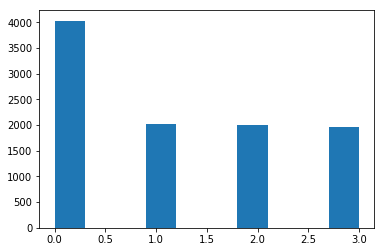

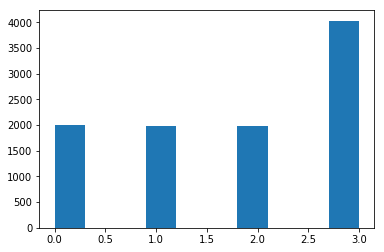

In [ ]:
# Sanity checking.

hashing_1 = ConsistentHashing(
    {0: 0.4, 1: 0.2, 2: 0.2, 3: 0.2})
choices_1 = list(map(hashing_1.hash, list(range(10000))))
pyplot.figure()
pyplot.hist(choices_1)

hashing_2 = ConsistentHashing(
    {0: 0.2, 1: 0.2, 2: 0.2, 3: 0.4})
choices_2 = list(map(hashing_2.hash, list(range(10000))))
pyplot.figure()
pyplot.hist(choices_2)

print("Choice swaps count:", sum(x != y for x, y in zip(choices_1, choices_2)))